# Intro. to Snorkel: Extracting Spouse Relations from the News

## Part IV: Training a Model with Data Programming

In this part of the tutorial, we will train a statistical model to differentiate between true and false `Spouse` mentions.

We will train this model using _data programming_, and we will **ignore** the training labels provided with the training data. This is a more realistic scenario; in the wild, hand-labeled training data is rare and expensive. Data programming enables us to train a model using only a modest amount of hand-labeled data for validation and testing. For more information on data programming, see the [NIPS 2016 paper](https://arxiv.org/abs/1605.07723).

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os

# TO USE A DATABASE OTHER THAN SQLITE, USE THIS LINE
# Note that this is necessary for parallel execution amongst other things...
# os.environ['SNORKELDB'] = 'postgres:///snorkel-intro'

import numpy as np
from snorkel import SnorkelSession
session = SnorkelSession()

/Users/juanbanda/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


We repeat our definition of the `Spouse` `Candidate` subclass from Parts II and III.

In [2]:
from snorkel.models import candidate_subclass
Spouse = candidate_subclass('Spouse', ['person1', 'person2'])

# (1) Creating and Modeling a Noisy Training Set

Our biggest step in the data programming pipeline is the creation--_and modeling_--of a noisy training set.  We'll approach this in three main steps:

i. **Creating labeling functions (LFs):** Here's where most of our development time would actually go into if this were a real application; labeling functions encode our heuristics and weak supervision signals to generate (noisy) labels for our training candidates

ii. **Applying the LFs:** Here, we actually use them to label our candidates!

iii. **Training a generative model of our training set:** Here we learn a model over our LFs, learning their respective accuracies automatically

## (1.i) Creating Labeling Functions
Labeling functions are a core tool of data programming. They are heuristic functions that aim to classify candidates correctly. Their outputs will be automatically combined and denoised to estimate the probabilities of training labels for the training data.

In [3]:
import re
from snorkel.lf_helpers import (
    get_left_tokens, get_right_tokens, get_between_tokens,
    get_text_between, get_tagged_text,
)

In [4]:
spouses = {'spouse', 'wife', 'husband', 'ex-wife', 'ex-husband'}
family = {'father', 'mother', 'sister', 'brother', 'son', 'daughter',
              'grandfather', 'grandmother', 'uncle', 'aunt', 'cousin'}
family = family | {f + '-in-law' for f in family}
other = {'boyfriend', 'girlfriend' 'boss', 'employee', 'secretary', 'co-worker'}

# Helper function to get last name
def last_name(s):
    return s.split(' ')[-1]

def LF_husband_wife(c):
    return 1 if len(spouses.intersection(set(get_between_tokens(c)))) > 0 else 0

def LF_husband_wife_left_window(c):
    if len(spouses.intersection(set(get_left_tokens(c[0], window=2)))) > 0:
        return 1
    elif len(spouses.intersection(set(get_left_tokens(c[1], window=2)))) > 0:
        return 1
    else:
        return 0
    
def LF_same_last_name(c):
    if last_name(c.person1.get_span()) == last_name(c.person2.get_span()):
        if c.person1.get_span() != c.person2.get_span():
            return 1
    elif np.random.rand() < 0.50:
        return -1
    return 0

def LF_no_spouse_in_sentence(c):
    return -1 if np.random.rand() < 0.25 and len(spouses.intersection(set(c.get_parent().words))) == 0 else 0

def LF_and_married(c):
    return 1 if 'and' in get_between_tokens(c) and 'married' in get_right_tokens(c) else 0
    
def LF_familial_relationship(c):
    return -1 if len(set(family).intersection(set(get_between_tokens(c)))) > 0 else 0

def LF_family_left_window(c):
    if len(family.intersection(set(get_left_tokens(c[0], window=2)))) > 0:
        return -1
    elif len(family.intersection(set(get_left_tokens(c[1], window=2)))) > 0:
        return -1
    else:
        return 0

def LF_other_relationship(c):
    coworker = ['boss', 'employee', 'secretary', 'co-worker']
    return -1 if len(set(coworker).intersection(set(get_between_tokens(c)))) > 0 else 0

In addition to writing labeling functions that describe text pattern-based heuristics for labeling training examples, we can also write labeling functions that distantly supervise examples. Here, we'll load in a list of known spouse pairs and check to see if the candidate pair matches one of these.

In [5]:
import bz2

# Function to remove special characters from text
def strip_special(s):
    return ''.join(c for c in s if ord(c) < 128)

# Read in known spouse pairs and save as set of tuples
with bz2.BZ2File('data/spouses_dbpedia.csv.bz2', 'rb') as f:
    known_spouses = set(
        tuple(strip_special(x).strip().split(',')) for x in f.readlines()
    )
# Last name pairs for known spouses
last_names = set((last_name(x), last_name(y)) for x, y in known_spouses)
    
def LF_distant_supervision(c):
    p1, p2 = c.person1.get_span(), c.person2.get_span()
    return 1 if (p1, p2) in known_spouses or (p2, p1) in known_spouses else 0

def LF_distant_supervision_last_names(c):
    p1, p2 = c.person1.get_span(), c.person2.get_span()
    p1n, p2n = last_name(p1), last_name(p2)
    return 1 if (p1 != p2) and ((p1n, p2n) in last_names or (p2n, p1n) in last_names) else 0

For later convenience we group the labeling functions into a list.

In [6]:
LFs = [
    LF_distant_supervision, LF_distant_supervision_last_names, 
    LF_husband_wife, LF_husband_wife_left_window, LF_same_last_name,
    LF_no_spouse_in_sentence, LF_and_married, LF_familial_relationship, 
    LF_family_left_window, LF_other_relationship
]

## (1.ii) Applying the Labeling Functions

Next, we need to actually execute the LFs over all of our training candidates, producing a set of `Labels` and `LabelKeys` (just the names of the LFs) in the database.  We'll do this using the `LabelAnnotator` class, a UDF which we will again run with `UDFRunner`.  **Note that this will delete any existing `Labels` and `LabelKeys` for this candidate set.**  We start by setting up the class:

In [7]:
from snorkel.annotations import LabelAnnotator
labeler = LabelAnnotator(f=LFs)

Finally, we run the `labeler`; again, this can be run in parallel, given an appropriate database like Postrges is being used:

In [8]:
%time L_train = labeler.apply(split=0)

Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 53.5 s, sys: 498 ms, total: 54 s
Wall time: 58.4 s


If we've already created the labels (saved in the database), we can load them in as a sparse matrix here too:

In [9]:
L_train = labeler.load_matrix(session, split=0)

Note that the returned matrix is a special subclass of the `scipy.sparse.csr_matrix` class, with some special features which we demonstrate below:

In [10]:
L_train

<4790x10 sparse matrix of type '<type 'numpy.float64'>'
	with 4423 stored elements in Compressed Sparse Row format>

In [11]:
L_train.get_candidate(session, 0)

Spouse(Span("Rudy", sentence=12622, chars=[33,36], words=[7,7]), Span("Rebecca", sentence=12622, chars=[24,30], words=[5,5]))

In [12]:
L_train.get_key(session, 0)

LabelKey (LF_distant_supervision)

We can view statistics about the resulting label matrix:

In [13]:
L_train.lf_stats(session)

,j,coverage,overlaps,conflicts
LF_distant_supervision,0,0.000835,0.000835,0.000626
LF_distant_supervision_last_names,1,0.016910,0.016493,0.005637
LF_husband_wife,2,0.036743,0.031106,0.021086
LF_husband_wife_left_window,3,0.028601,0.026096,0.018163
LF_same_last_name,4,0.498121,0.179541,0.032359
LF_no_spouse_in_sentence,5,0.239040,0.125261,0.007516
LF_and_married,6,0.000835,0.000418,0.000418
LF_familial_relationship,7,0.053445,0.046764,0.011482
LF_family_left_window,8,0.041336,0.038622,0.006263
LF_other_relationship,9,0.007516,0.005637,0.000209


## (1.iii) Fitting the Generative Model
We estimate the accuracies of the labeling functions without supervision. Specifically, we estimate the parameters of a `NaiveBayes` generative model.

In [14]:
from snorkel.learning import GenerativeModel

gen_model = GenerativeModel()
gen_model.train(L_train, epochs=500, decay=0.95, step_size=0.1/L_train.shape[0], reg_param=1e-6)

/Users/juanbanda/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


We now apply the generative model to the training candidates.

In [15]:
train_marginals = gen_model.marginals(L_train)

We can view the learned parameters.

In [16]:
gen_model.weights.lf_accuracy()

array([ 0.51750718,  0.51887272,  0.51622621,  0.51894474,  0.62103698,
        0.56390335,  0.51638456,  0.52941314,  0.52811139,  0.52080433])

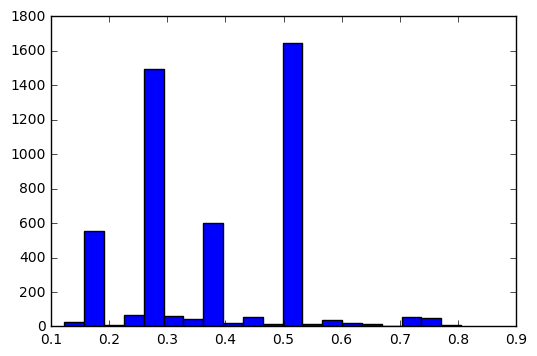

In [17]:
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20)
plt.show()

# (2) Training our Primary Model

Next, we use the training set we've generated--now stored as an array of `training_marginals`--to train a discriminative model.  This part more closely follows a traditional ML process, and will consist of two steps:

i. **Create features**

ii. **Train our model**

## (2.i) Automatically Creating Features
Recall that our goal is to distinguish between true and false mentions of spouse relations. To train a model for this task, we first embed our `Spouse` candidates in a feature space. Here, we use the `FeatureAnnotator` UDF, which uses the default Snorkel features by default:

In [18]:
from snorkel.annotations import FeatureAnnotator
featurizer = FeatureAnnotator()

In [19]:
%time F_dev = featurizer.apply(split=0)

Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 13min 17s, sys: 8.36 s, total: 13min 26s
Wall time: 15min 21s


And again, if we've already computed the features, we can load them in here:

In [20]:
F_train = featurizer.load_matrix(session, split=0)
F_train

<4790x119615 sparse matrix of type '<type 'numpy.float64'>'
	with 281790 stored elements in Compressed Sparse Row format>

## (2.ii) Training the Discriminative Model
We use the estimated probabilites to train a discriminative model that classifies each `Candidate` as a true or false mention. We'll use a random hyperparameter search, evaluated on the development set labels, to find the best hyperparameters for our model. To run a hyperparameter search, we need labels for a development set. If they aren't already available, we can manually create labels using the Viewer.

In [21]:
from snorkel.learning import LogisticRegression
disc_model = LogisticRegression()

First, we create features for the development set candidates.

Note that we use the training feature set, because those are the only features for which we have learned parameters. Features that were not encountered during training, e.g., a token that does not appear in the training set, are ignored, because we do not have any information about them.

**To use the set of training features (FeatureKeys) we already created, we use `apply_existing` when applying the featurizer to the dev set:**

In [22]:
%time F_dev = featurizer.apply_existing(split=1)
F_dev

Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 33.9 s, sys: 722 ms, total: 34.7 s
Wall time: 41.6 s


<223x119615 sparse matrix of type '<type 'numpy.float64'>'
	with 5612 stored elements in Compressed Sparse Row format>

Next, we load the development set labels and gold candidates we made in Part III.

In [23]:
from snorkel.annotations import load_gold_labels
L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1)

Now we set up and run the hyperparameter search, training our model with different hyperparamters and picking the best model configuration to keep. We'll set the random seed to maintain reproducibility.

Note that we are fitting our model's parameters to the training set generated by our labeling functions, while we are picking hyperparamters with respect to score over the development set labels which we created by hand.

In [24]:
from snorkel.learning.utils import MentionScorer
from snorkel.learning import RandomSearch, ListParameter, RangeParameter

rate_param = RangeParameter('lr', 1e-4, 0.1, step=1, log_base=10)
reg_param  = RangeParameter('l1_penalty', 1e-6, 1.0, step=1, log_base=10)

searcher = RandomSearch(session, disc_model, F_train, train_marginals, [rate_param, reg_param], n=5)

Initialized RandomSearch search of size 5. Search space size = 28.


In [25]:
np.random.seed(1701)
searcher.fit(F_dev, L_gold_dev)

Testing lr = 1.00e-02, l1_penalty = 1.00e-03
[LR] lr=0.01 l1=0.001 l2=0.0
[LR] Building model
[LR] Training model  #epochs=10  batch=100
[LR] Epoch 0 (5.74s)	Average loss=0.930114
[LR] Epoch 5 (24.26s)	Average loss=0.827132
[LR] Epoch 9 (38.63s)	Average loss=0.825599
[LR] Training done (38.63s)
[LR] Model saved. To load, use name
		LR_0
Testing lr = 1.00e-04, l1_penalty = 1.00e-03
[LR] lr=0.0001 l1=0.001 l2=0.0
[LR] Building model
[LR] Training model  #epochs=10  batch=100
[LR] Epoch 0 (3.75s)	Average loss=0.810485
[LR] Epoch 5 (20.99s)	Average loss=0.783558
[LR] Epoch 9 (34.83s)	Average loss=0.775717
[LR] Training done (34.83s)
Testing lr = 1.00e-02, l1_penalty = 1.00e-01
[LR] lr=0.01 l1=0.1 l2=0.0
[LR] Building model
[LR] Training model  #epochs=10  batch=100
[LR] Epoch 0 (3.81s)	Average loss=0.809831
[LR] Epoch 5 (21.17s)	Average loss=0.782811
[LR] Epoch 9 (35.06s)	Average loss=0.782812
[LR] Training done (35.06s)
Testing lr = 1.00e-02, l1_penalty = 1.00e-02
[LR] lr=0.01 l1=0.01 l2=

,lr,l1_penalty,Prec.,Rec.,F1
0,0.0100,0.001000,0.03139,1.0,0.06087
1,0.0001,0.001000,0.03139,1.0,0.06087
2,0.0100,0.100000,0.03139,1.0,0.06087
3,0.0100,0.010000,0.03139,1.0,0.06087
4,0.0100,0.000001,0.03139,1.0,0.06087


_Note that to train a model without tuning any hyperparameters (at your own risk!) just use the `train` method of the discriminative model. For instance, to train with a learning rate of 0.01 and an l1 penalty parameter of 0.5, you could run:_
```
disc_model.train(F_train, train_marginals, lr=0.01, l1_penalty=0.5)
```

We can save the best model from the hyperparameter search with a custom name so that we can reload it later.

In [26]:
disc_model.save('SpouseLR')

[LR] Model saved. To load, use name
		SpouseLR


Now we'll use the `score` function to see the dev set candidates that were true positives, false positives, true negatives, and false negatives according to the model's predictions.

In [27]:
tp, fp, tn, fn = disc_model.score(session, F_dev, L_gold_dev)

Scores (Un-adjusted)
Pos. class accuracy: 1.0
Neg. class accuracy: 0.0
Precision            0.0314
Recall               1.0
F1                   0.0609
----------------------------------------
TP: 7 | FP: 216 | TN: 0 | FN: 0



## Viewing Examples
After evaluating on the development `CandidateSet`, the labeling functions can be modified. Try changing the labeling functions to improve performance. You can view the true positives, false positives, true negatives, and false negatives using the `Viewer`.

In [31]:
from snorkel.viewer import SentenceNgramViewer

# NOTE: This if-then statement is only to avoid opening the viewer during automated testing of this notebook
# You should ignore this!
import os
#if 'CI' not in os.environ:
sv = SentenceNgramViewer(fn, session, annotator_name="Tutorial Part IV User")
#else:
#    sv = None

<IPython.core.display.Javascript object>

In [32]:
sv

Next, in Part V, we will test our model on the test `CandidateSet`.